# Introduction

In this notebook, my goal is to explore and propose a solution to a credit card customer churn analysis.

Data is available on Kaggle: https://www.kaggle.com/sakshigoyal7/credit-card-customers

[WIP] Next steps: 
    - Dig deeper into outliers
    - Possibly create separate model for them
    - Suggest deployment structure

# Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

# Read CSV

In [2]:
df = pd.read_csv("BankChurners.csv")

# Remove last two columns
df = df.iloc[:,:21]

df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
# Check for null values
df.isna().sum().any()

False

In [4]:
# Make target binary
df["Attrition_Flag"] = df["Attrition_Flag"].apply(lambda x: 0 if x == 'Existing Customer' else 1)

df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Data split

In [5]:
X = df.loc[:,df.columns != "Attrition_Flag"]

y = df[["Attrition_Flag"]]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

In [7]:
# Remove client id column from train set
X_train = X_train.iloc[:,1:]

X_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
2462,37,F,1,High School,Married,$40K - $60K,Blue,25,4,3,4,5865.0,2517,3348.0,1.348,2623,47,1.350,0.429
3643,44,F,3,High School,Married,Unknown,Blue,38,4,6,4,26516.0,1434,25082.0,0.472,3609,76,0.551,0.054
4824,45,F,0,Unknown,Married,$40K - $60K,Blue,30,3,2,4,2759.0,0,2759.0,0.535,2061,47,0.424,0.000
9049,44,F,5,Uneducated,Single,Less than $40K,Blue,36,1,3,1,7742.0,1163,6579.0,0.729,9081,100,0.852,0.150
1334,36,M,3,Graduate,Married,$60K - $80K,Blue,27,4,3,2,12397.0,1001,11396.0,0.756,1888,42,0.448,0.081


In [8]:
X_train.shape

(7088, 19)

# Initial Analysis

## Target

There is a class imbalance in the dataset

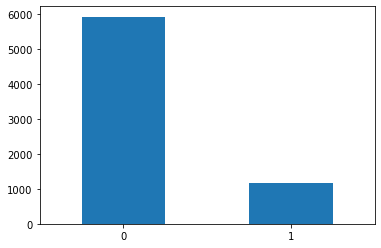

In [9]:
y_train.iloc[:,0].value_counts().plot(kind = "bar", rot = 0)

## Feature type

In [10]:
num_vars = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
            'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
            'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

cat_vars = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

## Correlation

There seems to be a high correlation between "Avg_Open_To_Buy" and "Credit_Limit" features

In [11]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Customer_Age,1.000000,-0.140439,0.785389,-0.013863,0.050617,-0.014647,-0.002483,0.005760,-0.003006,-0.061531,-0.053938,-0.079172,-0.017431,0.002476
Dependent_count,-0.140439,1.000000,-0.118854,-0.046711,-0.017891,-0.032119,0.073893,0.006997,0.073323,-0.033814,0.033703,0.053783,0.010153,-0.031031
Months_on_book,0.785389,-0.118854,1.000000,-0.010586,0.072521,-0.003281,0.006810,0.001576,0.006673,-0.038759,-0.038760,-0.057562,-0.018327,-0.013305
Total_Relationship_Count,-0.013863,-0.046711,-0.010586,1.000000,-0.012013,0.058185,-0.076980,0.011329,-0.078070,0.055672,-0.335210,-0.232857,0.054497,0.070239
Months_Inactive_12_mon,0.050617,-0.017891,0.072521,-0.012013,1.000000,0.032119,-0.031003,-0.053076,-0.026227,-0.047020,-0.043270,-0.049496,-0.050144,-0.009267
Contacts_Count_12_mon,-0.014647,-0.032119,-0.003281,0.058185,0.032119,1.000000,0.007186,-0.051972,0.011894,-0.030604,-0.116021,-0.155786,-0.090193,-0.053907
Credit_Limit,-0.002483,0.073893,0.006810,-0.076980,-0.031003,0.007186,1.000000,0.054552,0.995911,-0.000648,0.175681,0.078248,-0.002214,-0.473337
Total_Revolving_Bal,0.005760,0.006997,0.001576,0.011329,-0.053076,-0.051972,0.054552,1.000000,-0.035879,0.059943,0.063012,0.051252,0.090445,0.623820
Avg_Open_To_Buy,-0.003006,0.073323,0.006673,-0.078070,-0.026227,0.011894,0.995911,-0.035879,1.000000,-0.006072,0.170129,0.073677,-0.010399,-0.530179
Total_Amt_Chng_Q4_Q1,-0.061531,-0.033814,-0.038759,0.055672,-0.047020,-0.030604,-0.000648,0.059943,-0.006072,1.000000,0.039780,0.008470,0.363369,0.047316


In [12]:
# Remove one of them, decided to remove Credit_Limit at first
X_train = X_train.drop(columns = "Credit_Limit")

num_vars.remove("Credit_Limit")

## Feature EDA

### Categorical Features

We can see a high churn ratio amongst Platinum card users

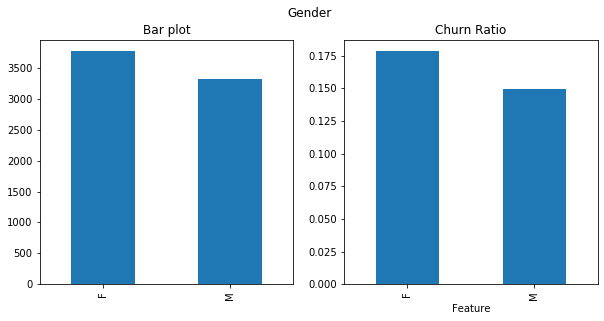

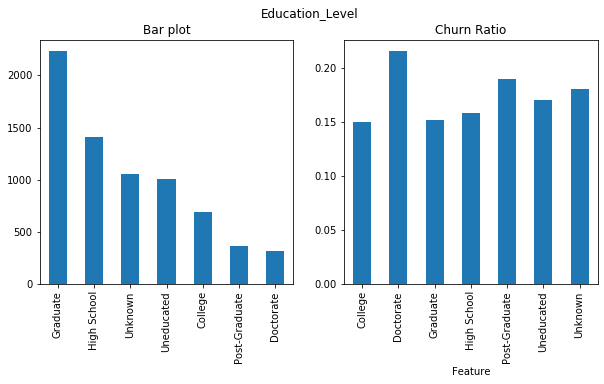

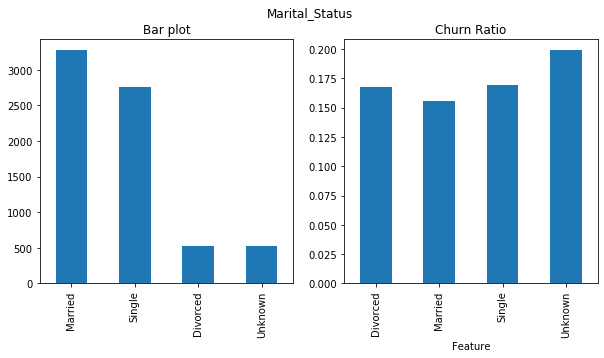

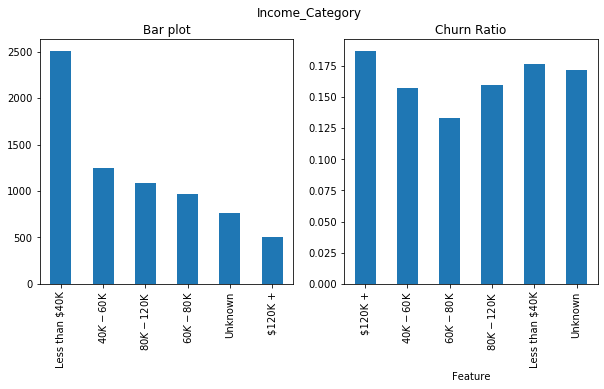

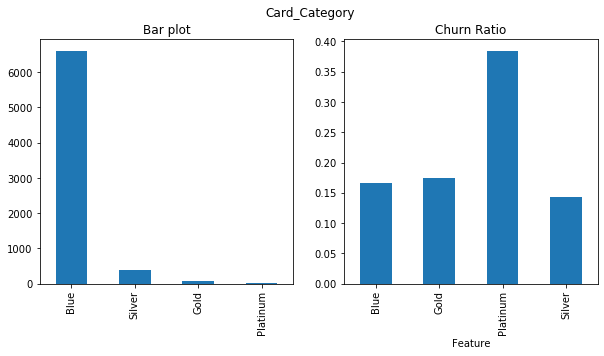

In [13]:
for var in cat_vars:
    # Join training objects into a single dataframe
    feat = pd.DataFrame({"Feature": X_train[var].values, "target": y_train["Attrition_Flag"].values})
    # Aggregate count and sum to calculate ratio
    feat = feat.groupby(by = "Feature").agg(count = pd.NamedAgg(column = "target", aggfunc = "count"),
                                            sum = pd.NamedAgg(column = "target", aggfunc = "sum"))
    feat['churn_ratio'] = feat['sum']/feat['count']
    
    # Create subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 4.5])
    fig.suptitle(var)
    X_train[var].value_counts().plot(kind = 'bar', ax = ax1, title = "Bar plot")
    feat['churn_ratio'].plot(kind = 'bar', ax = ax2, title = "Churn Ratio")
    
    plt.show()

### Numerical Features

For numerical features, we can see some interesting things.
- As expected, clients who holds more products, tend to be more loyal than those with less products. (Total_Relationship_Count)
- Clients who less than two months, also tend to churn less. However, if the clients stays inactive for 3 or 4 months, chances are higher that they will cancel their products. (Months_Inactive_12_mon)
- Also, the more the client has to get in touch with the bank, the more insatified they are. (Contacts_Count_12_mon)
... and so on

As for outliers, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt and Total_Ct_Chng_Q4_Q1 features must be treated more closel

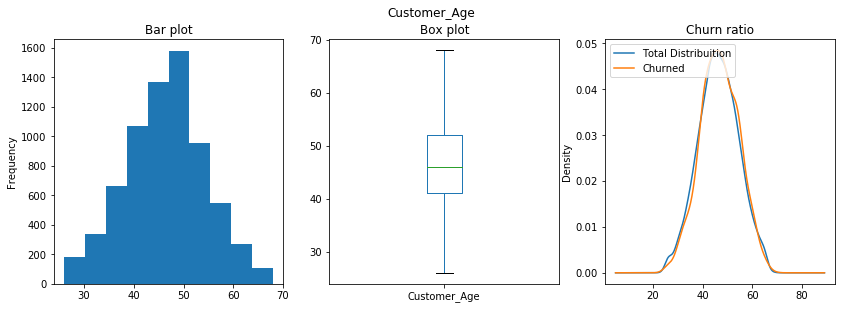

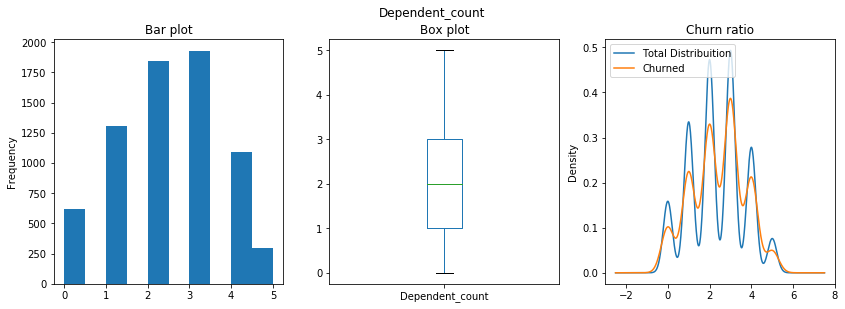

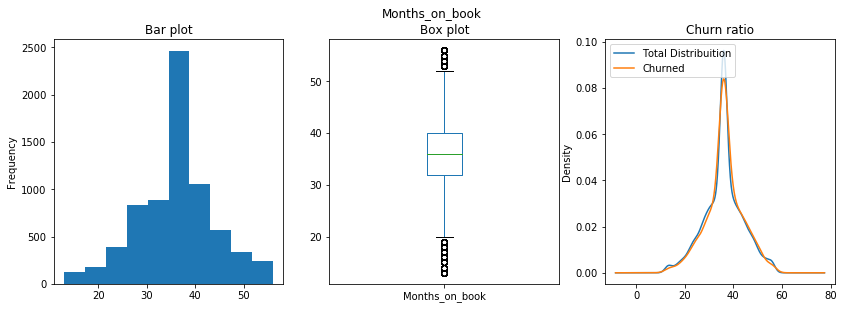

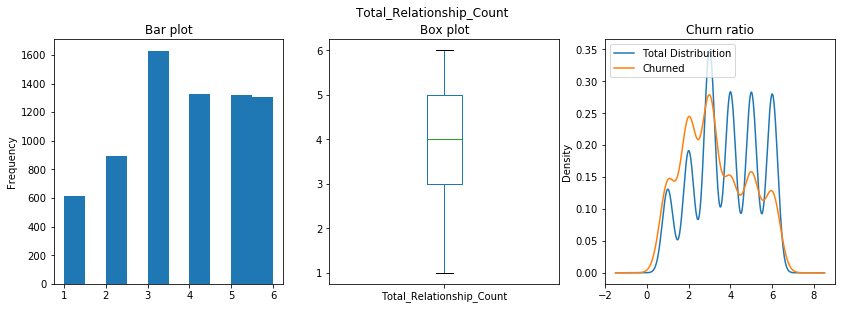

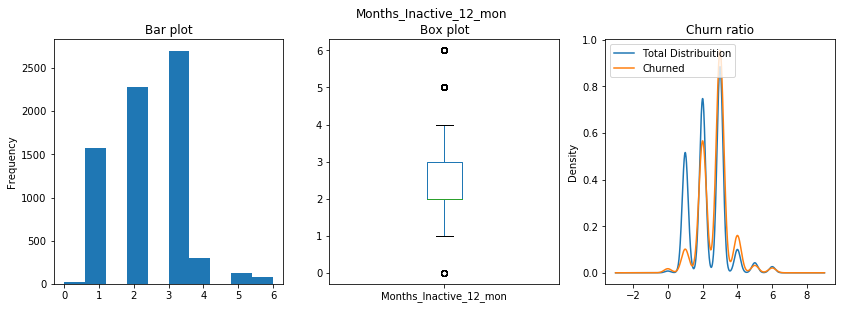

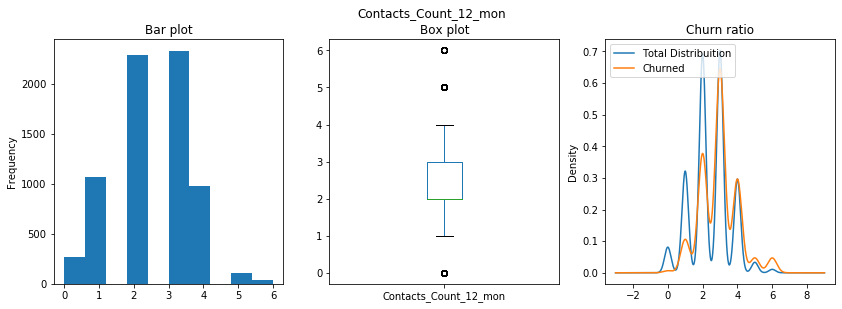

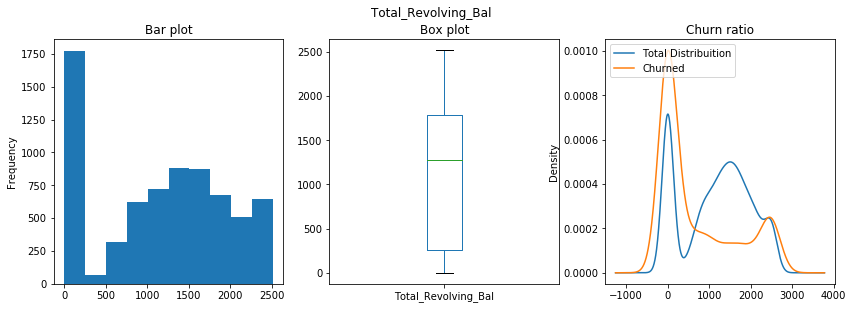

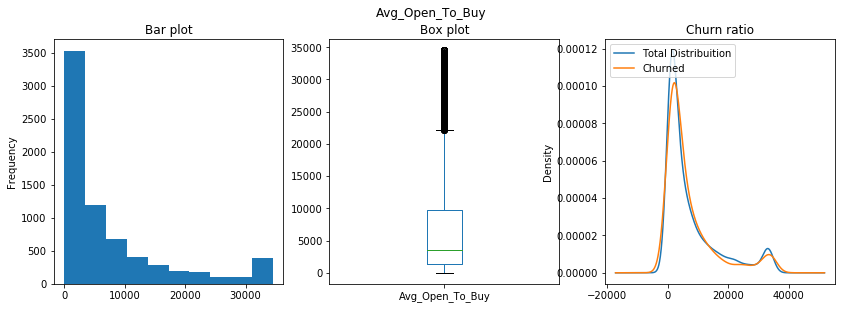

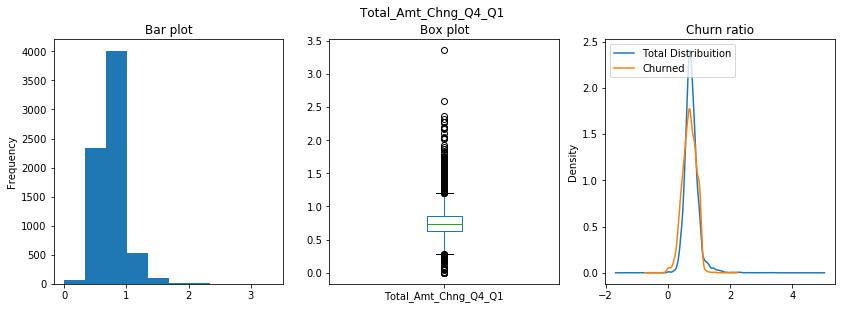

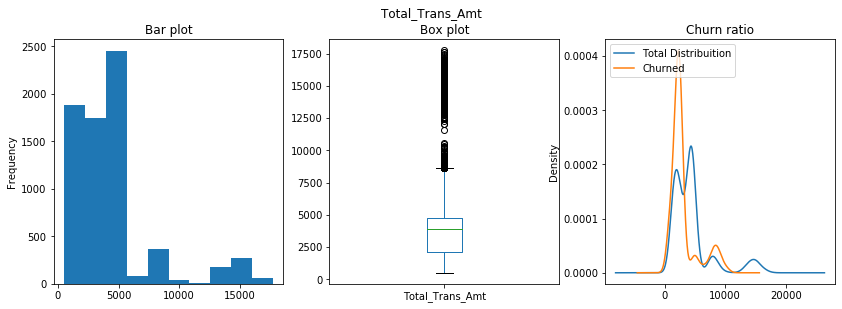

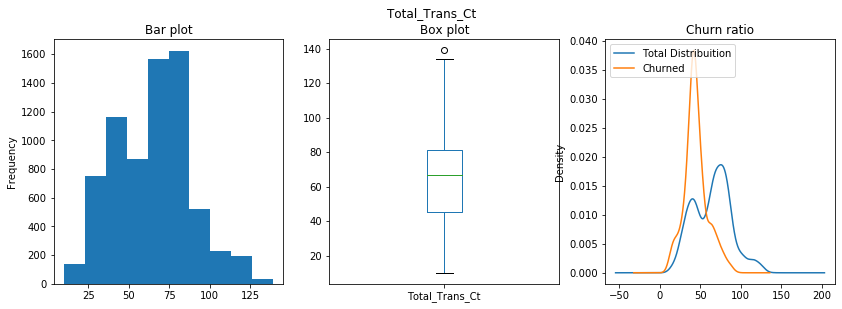

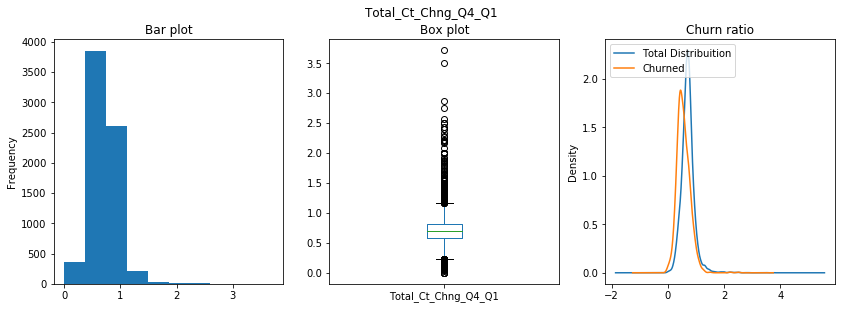

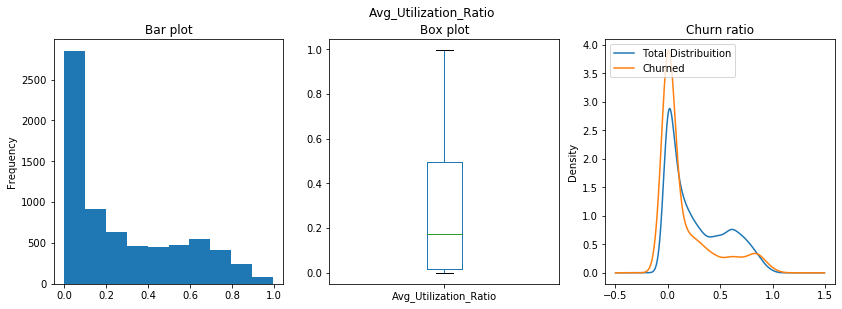

In [14]:
for var in num_vars:
    # Join training objects into a single dataframe
    feat = pd.DataFrame({"Feature": X_train[var].values, "target": y_train["Attrition_Flag"].values})
    
    # Create subplot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [14, 4.5])
    fig.suptitle(var)
    
    X_train[var].plot(kind = 'hist', ax = ax1, title = "Bar plot")
    
    X_train[var].plot(kind = 'box', ax = ax2, title = "Box plot")
    
    feat["Feature"].plot(kind = 'kde', ax = ax3, title = "Churn ratio", label = "Total Distribuition")
    feat.loc[feat["target"] == 1, "Feature"].plot(kind = 'kde', ax = ax3, label = "Churned")
    ax3.legend(loc = 2)
    
    plt.show()

### Bi-variate analysis

We could plot all features against each other and see how they behave. For simplicity, all plot an example of categorical vs categorical, categorical vs numerical and numerical vs numerical

#### Education_Level vs Income_Category

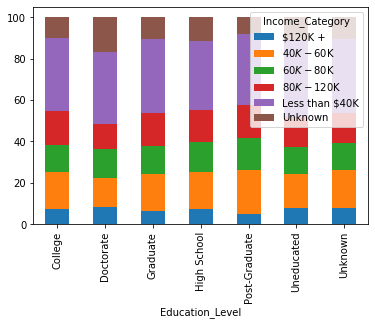

In [15]:
bivariate_cat = X_train[['Education_Level', 'Income_Category', 'Gender']].groupby(by = ['Education_Level', 'Income_Category']).agg(count = pd.NamedAgg(column = 'Gender', aggfunc = 'count'))

bivariate_cat = bivariate_cat.reset_index().pivot(index = 'Education_Level', columns = 'Income_Category', values = 'count')

# Sum row-wise
bivariate_cat['Total'] = bivariate_cat.sum(axis = 1)

# Calculate % by class, except Total
for column in bivariate_cat.columns:
    if column != 'Total':
        bivariate_cat[column] = 100*(bivariate_cat[column]/bivariate_cat['Total'])

# Plot without Total column
bivariate_cat.drop(columns = 'Total').plot.bar(stacked = True)

#### Gender vs Avg_Open_To_Buy

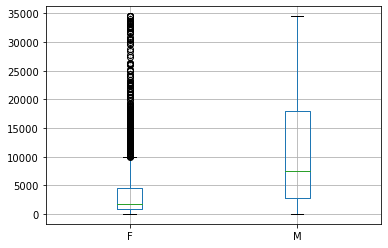

In [16]:
ax = X_train[['Gender', 'Avg_Open_To_Buy']].pivot(columns = 'Gender').boxplot()

# Change x-axis labels
ax.set_xticklabels(['F', 'M'])

plt.show()

#### Total_Trans_Ct vs Avg_Utilization_Ratio

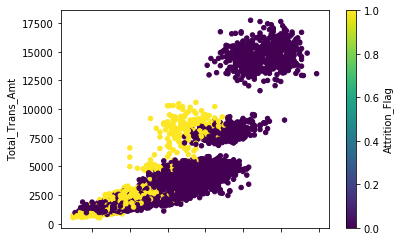

In [17]:
X_train[['Total_Trans_Amt', 'Total_Trans_Ct']].join(y_train).plot.scatter(x = 'Total_Trans_Ct', 
                                                                          y = 'Total_Trans_Amt', 
                                                                          c = 'Attrition_Flag',
                                                                          colormap = 'viridis')

# Pre Processing

## One Hot Encoding Categorical Features

In [18]:
# Create encoder
encoder = OneHotEncoder(drop = 'first', sparse = False)

# Fit encoder to categorical features
encoder.fit(X_train[cat_vars])

# Transform train set
X_encoded = encoder.transform(X_train[cat_vars])

# Concatenate one hot encoded categorical features with numerical
X_train_new = pd.DataFrame(X_encoded, columns = encoder.get_feature_names(cat_vars))

X_train_new = X_train_new.join(X_train[num_vars].reset_index(drop = True))

# Final training dataset
X_train_new.head()

,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,...,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4,3,4,2517,3348.0,1.348,2623,47,1.350,0.429
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4,6,4,1434,25082.0,0.472,3609,76,0.551,0.054
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,3,2,4,0,2759.0,0.535,2061,47,0.424,0.000
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,3,1,1163,6579.0,0.729,9081,100,0.852,0.150
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4,3,2,1001,11396.0,0.756,1888,42,0.448,0.081


## Balance classes

In [19]:
# Create SMOTE object to balance minority class
oversample = SMOTE()

# Apply SMOTE to training set
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_new, y_train)

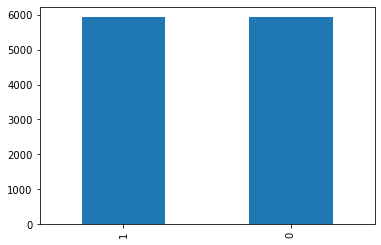

In [20]:
y_train_balanced.iloc[:,0].value_counts().plot(kind = 'bar')

# Baseline Model

In [21]:
# Parameters for cross-validation
cv = 5
scoring = 'roc_auc'

# Classifier
model_v1 = RandomForestClassifier(n_estimators = 100,
                                  max_depth = 4,
                                  criterion = 'entropy')

# Cross validation
scores_v1 = cross_val_score(model_v1,
                            X_train_balanced, 
                            y_train_balanced, 
                            scoring = scoring,
                            cv = cv)

print("Mean AUC: {}\nSTD: {}".format(scores_v1.mean(), scores_v1.std()))

Mean AUC: 0.9656201492878014
STD: 0.013020453174518085


Not too shabby of a result for a first try

## Performance on Test set

In [22]:
# Apply same transformations to test set
X_test_encoded = encoder.transform(X_test[cat_vars])

X_test_new = pd.DataFrame(X_test_encoded, columns = encoder.get_feature_names(cat_vars))

X_test_new = X_test_new.join(X_test[num_vars].reset_index(drop = True))

X_test_new.head()

,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,...,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4,3,4,0,28701.0,1.165,3516,57,0.727,0.000
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,3,3,2,1924,1666.0,0.573,1472,37,0.762,0.536
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,5,3,4,0,19995.0,0.650,1879,34,0.700,0.000
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,6,4,3,0,2049.0,0.974,2703,54,1.000,0.000
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,5,3,5,0,2879.0,1.031,4684,56,0.556,0.000


In [23]:
# Create and fit classifier
model_v1 = RandomForestClassifier(n_estimators = 100,
                                  max_depth = 4,
                                  criterion = 'entropy')

model_v1 = model_v1.fit(X_train_balanced, 
                        y_train_balanced)

# Predict values from test set
pred_v1 = model_v1.predict_proba(X_test_new)

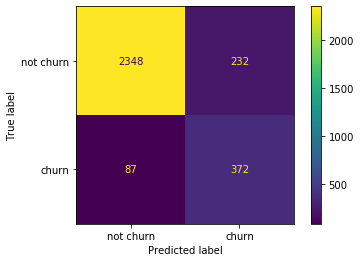

In [24]:
# Create confusion matrix
cm = confusion_matrix(y_test, np.round(pred_v1[:,1]).tolist())

cmd = ConfusionMatrixDisplay(cm, display_labels=['not churn','churn'])
cmd.plot()

Precision needs improving

AUC:  0.939715593386364


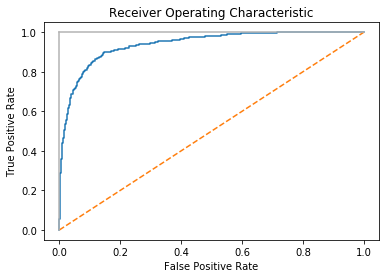

In [25]:
# Create ROC curve variables
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_v1[:,1])

# Print model AUC
print('AUC: ', roc_auc_score(y_test, pred_v1[:,1]))

# Ploting ROC curves
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()